## Basics

In [1]:
from primitives import Parameters
p = Parameters()
import pickle
import matplotlib.pyplot as plt
import numpy as np
from plots import Plots
plts=Plots(p)
cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc,mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n1,mwc_s_J,mwc_s_W,mwc_s_Wstar,mwc_s_sep,mwc_sd_J,mwc_sd_W,mwc_sd_Wstar,mwc_sd_sep=None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None

In [2]:
# Step 1: Load the existing objects from the file
try:
    with open('my_objects.pkl', 'rb') as file:
        objects = pickle.load(file)
except FileNotFoundError:
    # If the file doesn't exist, start with an empty dictionary
    objects = {}

In [3]:
from ContinuousContract import ContinuousContract
cc=ContinuousContract(p)
(cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc)=cc.J(0)

In [4]:
# Retrieve the objects
mwc_hmq_J = objects['mwc_hmq_J']
mwc_hmq_W = objects['mwc_hmq_W']

from Multiworker_Contract_hire_hmq import MultiworkerContract
K=2 #number of tenure levels
mwc_hmq=MultiworkerContract(p,cc.js)
(mwc_hmq_J,mwc_hmq_W,mwc_hmq_Wstar,mwc_hmq_pc,mwc_hmq_n0,mwc_hmq_n1)=mwc_hmq.J(mwc_hmq_J,mwc_hmq_W)

#still to do: introduce HMQ into the separations.
#also gotta check that his actually works.
#also this seems slow af
objects['mwc_hmq_J'] = mwc_hmq_J
objects['mwc_hmq_W'] = mwc_hmq_W

with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

Ji shape (1, 5, 5, 100, 6)
W1i shape (1, 5, 5, 100, 6, 2)
Errors: 7.33015459954654e-09 2.9557694734752315e-26 1
EJinv 21.70175254828954
EJderiv 27.03542292157187
EJinv diff 1j 2s: 0.16616468412055377
EJinv diff 1 sen: 0.5285202303816283
EJinv diff 2 sen: 0.22571206372095173
n0_star borders 0.0 0.0
EJinv 21.70175254829015
EJderiv 27.035422921572433
EJinv diff 1j 2s: 0.16616468412055826
EJinv diff 1 sen: 0.5285202303816241
EJinv diff 2 sen: 0.22571206372094724
n0_star borders 0.0 0.0
EJinv 21.701752548290756
EJderiv 27.035422921572977
EJinv diff 1j 2s: 0.16616468412056432
EJinv diff 1 sen: 0.5285202303816199
EJinv diff 2 sen: 0.22571206372093833
n0_star borders 0.0 0.0
EJinv 21.70175254829139
EJderiv 27.035422921573513
EJinv diff 1j 2s: 0.16616468412055777
EJinv diff 1 sen: 0.5285202303816157
EJinv diff 2 sen: 0.2257120637209306
n0_star borders 0.0 0.0
EJinv 21.701752548291967
EJderiv 27.03542292157404
EJinv diff 1j 2s: 0.16616468412055038
EJinv diff 1 sen: 0.5285202303816114
EJinv diff 

In [5]:
(mwc_hmq_sd_J,mwc_hmq_sd_W,mwc_hmq_sd_Wstar,mwc_hmq_sd_sep,mwc_hmq_sd_n0,mwc_hmq_sd_n1)=mwc_hmq.J_sep_dir(mwc_hmq_J,mwc_hmq_W)

Ji shape (1, 5, 5, 100, 6)
W1i shape (1, 5, 5, 100, 6, 2)
q_star [0.5 0.5 0.5 0.5 0.5 0.5]
Errors: 5.433854434666589e-09 1.535480817056584e-26 1
q_star [0.5 0.5 0.5 0.5 0.5 0.5]
EJinv 21.70175254831085
EJderiv 27.035422921590857
EJinv diff 1j 2s: 0.1661646841203438
EJinv diff 1 sen: 0.5285202303814678
EJinv diff 2 sen: 0.22571206372082098


c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_hire_hmq.py:1128: RuntimeWarning: invalid value encountered in multiply
  Ifire = ( (-EJderiv0-rho_star*(self.N_grid[self.grid[1]]+self.N_grid1[self.grid[2]])*pc_star*EWderiv0) + RhoderivQ0 * q0 / (self.N_grid[self.grid[1]]+self.N_grid[self.grid[2]]) - (EW1_star+re_star-EUi)/ self.pref.inv_utility_1d(self.v_0-self.p.beta*(EW1_star + re_star)) > 0) & (self.N_grid[self.grid[1]]+self.N_grid1[self.grid[2]] <= self.p.n_bar) & (-(EJderiv1+rho_star*self.N_grid1[self.grid[2]]*pc_star*EWderiv1)*pc_star - (EW1_star+re_star-EUi)/ self.pref.inv_utility_1d(self.v_0-self.p.beta*(0.5 * EUi + 0.5 * (EW1_star + re_star))) + RhoderivQ1 * q1 / (self.N_grid[self.grid[1]] * self.p.q_0+self.N_grid1[self.grid[2]]) < 0 )
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_hire_hmq.py:1128: RuntimeWarning: invalid value encountered in divide
  Ifire = ( (-EJderiv0-rho_star*(self.N_grid[self.grid[

q_star [1. 1. 1. 1. 1. 1.]
n0_star borders 0.0 0.0
sep borders 0.0 0.5
EJinv 21.701752854672385
EJderiv 22.794547702822854
EJinv diff 1j 2s: 0.04059171360012361
EJinv diff 1 sen: 0.528520230381467
EJinv diff 2 sen: 0.2257120637208042
q_star [1. 1. 1. 1. 1. 1.]
n0_star borders 0.0 0.0
sep borders 0.0 0.5
EJinv 24.974333757295735
EJderiv 25.513680026348823
EJinv diff 1j 2s: 0.019080175809607997
EJinv diff 1 sen: 0.5285202303814661
EJinv diff 2 sen: 0.22571206372079974
q_star [1. 1. 1. 1. 1. 1.]
n0_star borders 0.0 0.0
sep borders 0.0 0.5
EJinv 26.41119461409084
EJderiv 25.513679988058193
EJinv diff 1j 2s: 0.029141605927672752
EJinv diff 1 sen: 0.5285202303814652
EJinv diff 2 sen: 0.22571206372080865
q_star [1. 1. 1. 1. 1. 1.]
n0_star borders 0.0 0.0
sep borders 0.0 0.5
EJinv 27.292341817889234
EJderiv 25.51367995943271
EJinv diff 1j 2s: 0.058470439092427974
EJinv diff 1 sen: 0.5285202303814642
EJinv diff 2 sen: 0.22571206372090263
q_star [1. 1. 1. 1. 1. 1.]
n0_star borders 0.0 0.0
sep bo

In [ ]:
mwc_hmq_sd_n0[0,2,2,...]

In [ ]:
np.where(mwc_hmq_sd_n0-mwc_hmq_n0==np.max(mwc_hmq_sd_n0-mwc_hmq_n0))

In [ ]:
(mwc_hmq_s_J,mwc_hmq_s_W,mwc_hmq_s_Wstar,mwc_hmq_s_sep,mwc_hmq_s_n0,mwc_hmq_s_n1)=mwc_hmq.J_sep(mwc_hmq_J,mwc_hmq_W)

In [ ]:
# Retrieve the objects
mwch_J = objects['mwch_J']
mwch_W = objects['mwch_W']

from Multiworker_Contract_hire import MultiworkerContract
K=2 #number of tenure levels
mwch=MultiworkerContract(p,cc.js)
(mwch_J,mwch_W,mwch_Wstar,mwch_pc,mwch_n0,mwch_n1)=mwch.J(mwch_J,mwch_W)

objects['mwch_J'] = mwch_J
objects['mwch_W'] = mwch_W

with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

In [ ]:
(mwch_s_J,mwch_s_W,mwch_s_Wstar,mwch_s_sep,mwch_s_n0,mwch_s_n1)=mwch.J_sep(mwch_J,mwch_W)

In [ ]:
(mwch_sd_J,mwch_sd_W,mwch_sd_Wstar,mwch_sd_sep,mwch_sd_n0,mwch_sd_n1)=mwch.J_sep_dir(mwch_J,mwch_W)

In [ ]:
from Multiworker_Contract_all import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
(mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n0,mwc_n1)=mwc.J()

# Plots

In [ ]:
plts.CRSvsDRSvalue(cc_W,cc_J,mwc_W,mwc_J/mwc.N_grid[1],mwc_s_W,mwc_s_J,mwc_sd_W,mwc_sd_J,0)

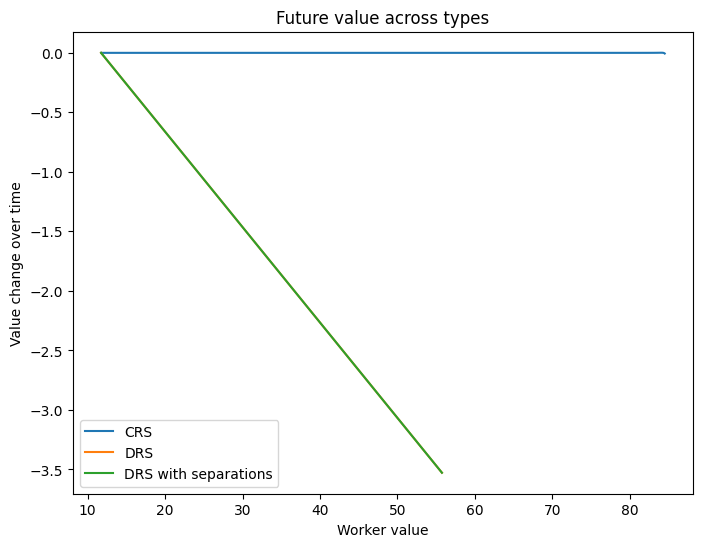

In [40]:
plts.CRSvsDRSpolicy(cc_W,cc_Wstar,mwc_hmq_W[...,0,:],mwc_hmq_Wstar[...,0],mwc_hmq_sd_W[...,0,:],mwc_hmq_sd_Wstar[...,0],mwc_sd_W,mwc_sd_Wstar,0)

In [ ]:
np.where(mwch_sd_sep==1)

In [18]:
mwc_hmq.rho_grid

array([0.01118034, 0.02695456, 0.04676295, 0.06990547, 0.09595649,
       0.1246214 , 0.15568047, 0.18896162, 0.22432531, 0.26165542,
       0.30085335, 0.34183399, 0.38452292, 0.42885433, 0.47476947,
       0.52221549, 0.5711445 , 0.62151284, 0.6732805 , 0.72641063,
       0.78086914, 0.83662439, 0.89364689, 0.95190908, 1.01138513,
       1.07205074, 1.13388304, 1.19686041, 1.26096239, 1.32616959,
       1.39246359, 1.45982686, 1.52824268, 1.5976951 , 1.66816888,
       1.73964941, 1.81212273, 1.8855754 , 1.95999455, 2.03536778,
       2.11168315, 2.18892919, 2.26709481, 2.34616932, 2.42614238,
       2.50700401, 2.58874456, 2.67135467, 2.75482529, 2.83914762,
       2.92431317, 3.01031365, 3.09714104, 3.18478753, 3.27324555,
       3.36250772, 3.45256685, 3.54341595, 3.63504822, 3.72745701,
       3.82063586, 3.91457845, 4.00927863, 4.10473037, 4.20092781,
       4.29786522, 4.39553698, 4.49393762, 4.59306178, 4.69290421,
       4.79345978, 4.89472347, 4.99669037, 5.09935565, 5.20271

In [17]:
mwc_hmq.pref.inv_utility(mwc_hmq.v_0*(1-p.beta))

0.049999999999999996

In [31]:
mwc_hmq.fun_prod[0,0,0,0,0]*mwc_hmq.prod[0,0,1,0,5]

4.0

In [33]:
mwc_hmq_Wstar[0,1,0,0,0]

11.731270855220979

In [37]:
mwc_hmq_sd_W[0,1,0,0,0,1]-mwc_hmq_W[0,1,0,0,0,1]

-4.626383685035762e-07

In [35]:
mwc_hmq_sd_Wstar[0,1,0,0,0]-mwc_hmq_Wstar[0,1,0,0,0]

-5.192890437655251e-07

In [12]:
mwc_hmq_J[0,0,1,50,5]-mwc_hmq_J[0,0,1,50,0]

14.095448187941239

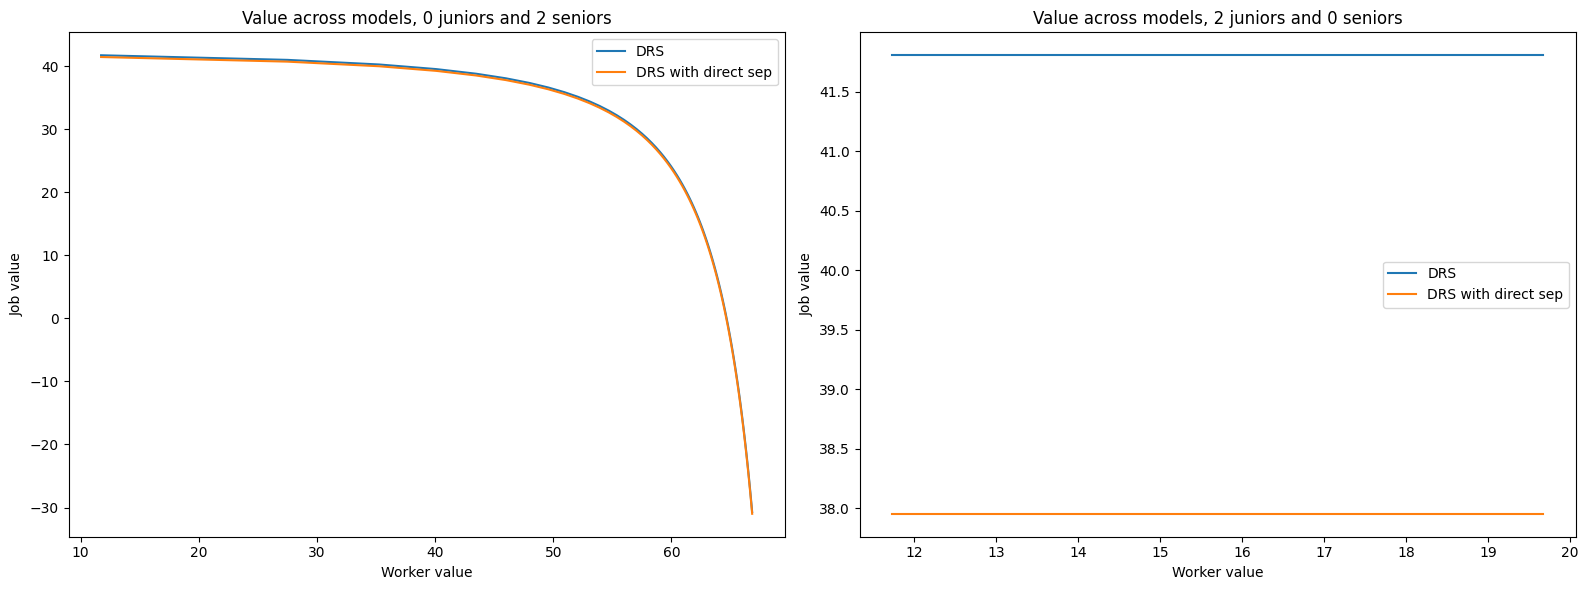

In [9]:
plts.ValueComparison(0,2,2,0,cc_W,cc_J,mwc_hmq_W[...,0,:],mwc_hmq_J[...,0],None,None,mwc_hmq_sd_W[...,0,:],mwc_hmq_sd_J[...,0],0)

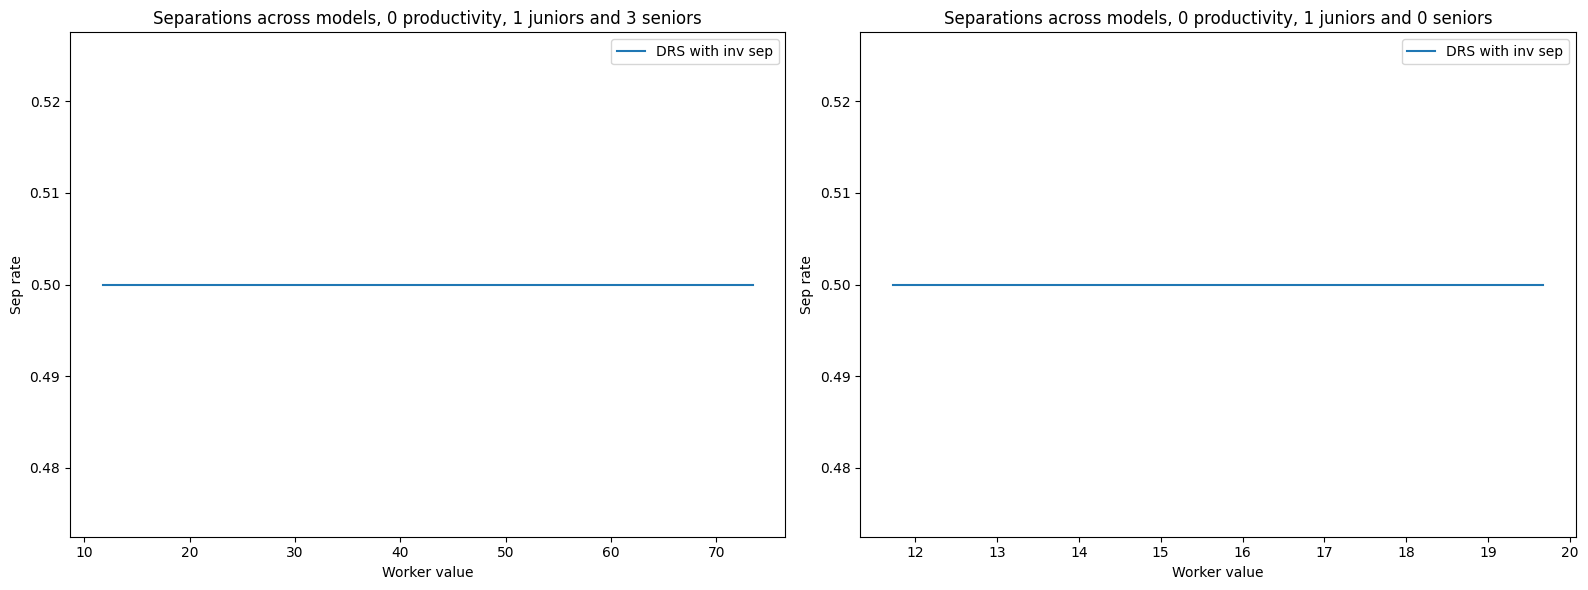

In [15]:
plts.sep(0,p.z_0-1,1,3,1,0,mwc_hmq_sd_W[...,5,:],mwc_hmq_sd_sep[...,5],None,None)

In [16]:
mwc_hmq_J[...,5]-mwc_hmq_J[...,4]

array([[[[0.17801715, 0.17801715, 0.17801715, ..., 0.17801715,
          0.17801715, 0.17801715],
         [2.78491079, 2.78491079, 2.78491079, ..., 2.78491103,
          2.78491103, 2.78491112],
         [4.87262207, 4.87262207, 4.87262208, ..., 4.87262289,
          4.87262289, 4.87262348],
         [6.70849317, 6.70849316, 6.70849317, ..., 6.70849483,
          6.70849484, 6.70849702],
         [8.38544435, 8.38544433, 8.38544434, ..., 8.38544658,
          8.38544661, 8.38545282]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [2.61642168, 2.61642168, 2.61642168, ..., 2.61642199,
          2.61642199, 2.616422  ],
         [4.71508849, 4.71508849, 4.7150885 , ..., 4.71508935,
          4.71508936, 4.71508937],
         [6.52316336, 6.52316337, 6.52316337, ..., 6.52316455,
          6.52316456, 6.52316458],
         [8.28984019, 8.28984019, 8.28984019, ..., 8.28984019,
          8.28984019, 8.28984019]],

        [[0.    

In [ ]:
plts.ValueComparison(0,2,1,0,cc_W,cc_J,mwch_W,mwch_J,mwch_s_W,mwch_s_J,mwch_sd_W,mwch_sd_J,0)

In [ ]:
plts.ValueComparison(0,2,1,0,cc_W,cc_J,mwc_W,mwc_J,mwch_W,mwch_J,mwc_sd_W,mwc_sd_J,0)

In [ ]:
#Only firings when n1=0? Shit

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
jun=0
sen=0

if mwch_W is not None:        
    plt.plot(mwch_W[p.z_0-1, jun, sen, :, 1], mwch_n0[p.z_0-1, jun, sen, :], label='DRS')
if mwch_s_W is not None:        
    plt.plot(mwch_s_W[p.z_0-1, jun, sen, :, 1], mwch_s_n0[p.z_0-1, jun, sen, :], label='DRS with inv sep')
if mwch_sd_W is not None:        
    plt.plot(mwch_sd_W[p.z_0-1, jun, sen, :, 1], mwch_sd_n0[p.z_0-1, jun, sen, :], label='DRS with direct sep')

plt.title(f'Hires across models, {jun} juniors and {sen} seniors')
plt.xlabel('Worker value')
plt.ylabel('Hires')
plt.legend()
#Why does the job value rise when separations go to 1?
#Alex: when something strange is arising at the edge of the grid, it might be the extrapolation issue.
#Is there a way to check my intuition? Seems consistent with size and productivity changes

In [ ]:
plts.CRSvsDRSdirect(cc_J,mwc_J,0)

In [ ]:
plts.CRSvsDRSsurplus(cc_J,cc_W,mwc_J,mwc_W,0)

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
np.abs(mwc_s_sep[:,:1,:3,:]-mwc_sd_sep[:,:1,:3,:]).max()

In [ ]:
np.max(np.abs(mwc_s_sep[:,3,0,:]-mwc_sd_sep[:,3,0,:]))

In [ ]:
np.max(mwc_sd_sep[:,1,1,:])

In [ ]:
mwc_sd_sep[:,1,1,:]

In [ ]:
mwc_s_J[:,1,0,:]/mwc_s_J[:,3,0,:] #this is odd, should be 1/3 exactly, no? it is 1/3 in the case without separations, so why not here? there aren't even any separations!

In [ ]:
np.max(mwc_s_sep[:,3,0,:])

In [ ]:
mwc_s_sep[0,1,1,:] #if the two value functions intersect, then how come the separation rate is 1?
#also thats way too many separations